Baseline
6 layers
class weights true
CEL
run this baseline again and again on each cuda (use different random seed)

Then, use the GATs instead

In [1]:
import os
import pickle
import random

random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize

In [2]:
def load_data_pickle(file_name, load_path):
    """
    Loads data from a Pickle (.pkl) file.
    
    Parameters:
        file_name (str): Name of the Pickle file.
        load_path (str): Directory where the file is stored.
    
    Returns:
        dict: The loaded data dictionary.
    """
    full_path = os.path.join(load_path, file_name)

    with open(full_path, 'rb') as file:
        data_dict = pickle.load(file)

    print(f"Data successfully loaded from {full_path}")
    return data_dict

load_path = "/storage/mxg1065"

In [3]:
model_GCNConv_seed42_a = load_data_pickle("model_6layers_seed_42_a.pkl", load_path)
model_GCNConv_seed42_b = load_data_pickle("model_6layers_seed_42_b.pkl", load_path)
model_GCNConv_seed0 = load_data_pickle("model_6layers_seed_0.pkl", load_path)
model_GAT_4_heads = load_data_pickle("model_6layers_GAT_4num_heads.pkl", load_path)
model_GAT_8_heads = load_data_pickle("model_6layers_GAT_8num_heads.pkl", load_path)

# Accessing data
print(model_GCNConv_seed42_a.keys())  # To check what keys are in the dictionary

Data successfully loaded from /storage/mxg1065/model_6layers_seed_42_a.pkl
Data successfully loaded from /storage/mxg1065/model_6layers_seed_42_b.pkl
Data successfully loaded from /storage/mxg1065/model_6layers_seed_0.pkl
Data successfully loaded from /storage/mxg1065/model_6layers_GAT_4num_heads.pkl
Data successfully loaded from /storage/mxg1065/model_6layers_GAT_8num_heads.pkl
dict_keys(['loss_per_epoch', 'scores', 'truth_labels', 'avg_loss_training_true_class', 'logits_training_true_class', 'avg_loss_testing_true_class', 'logits_testing_true_class', 'avg_loss_training_bkg_classes', 'logits_training_bkg_classes', 'avg_loss_testing_bkg_classes', 'logits_testing_bkg_classes'])


For the signal, set a threshold value so you get 90% (0.25 for first ROC Curve)

for the backgrounds, set at 0.1

# Model Details

Data Split: 80-20

Data configuration:
* Lone-Lone Pairs - Label 0 - 40,000 pairs
* True-True Pairs - Label 1 - 40,000 pairs
* Cluster-Lone Pairs - Label 2 - 40,000 pairs
* Lone-Cluster Pairs - Label 3 - 40,000 pairs
* Cluster-Cluster Pairs - Label 4 - 3,000 pairs

Number of epochs: 300

Optimizer: Adam

Scheduler: Exponential learning rate with $\gamma = 0.97$

Loss type: Cross Entropy Loss 

Class weights: True

Number of Model Layers: 6

Main Model Layer: GCNConv

Random Seed: 42

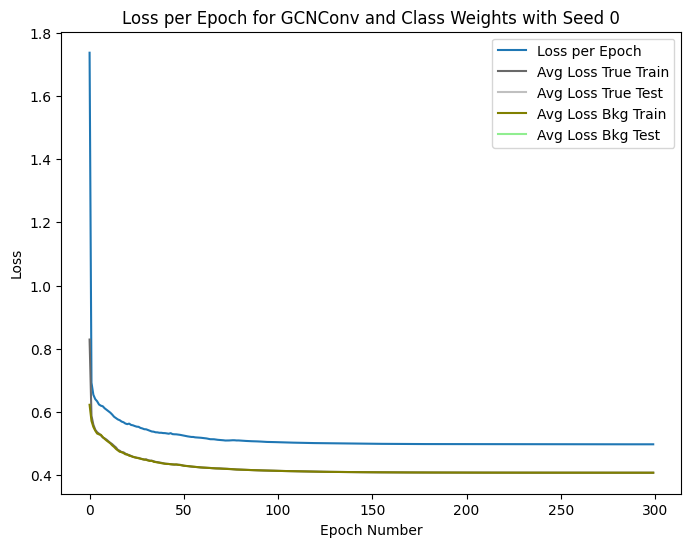

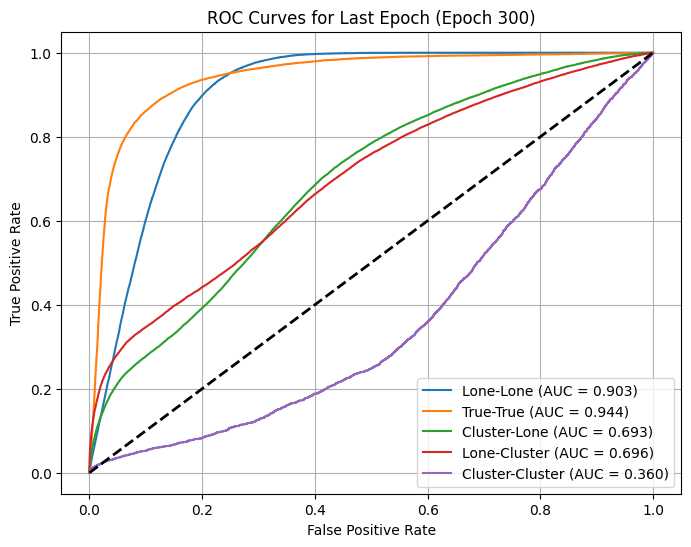

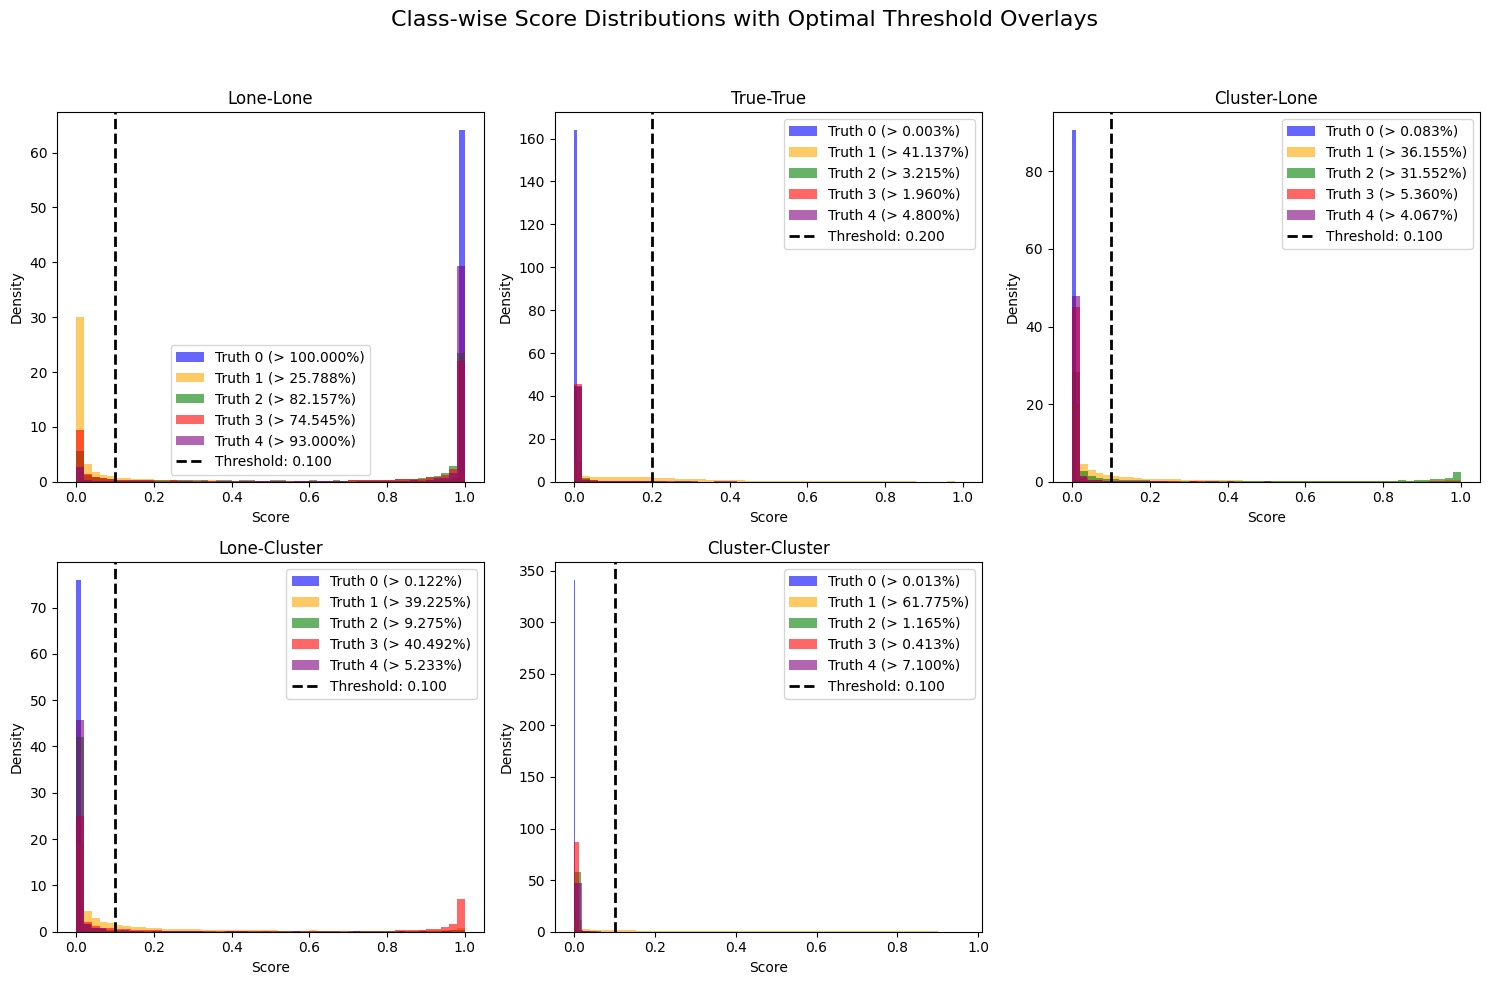

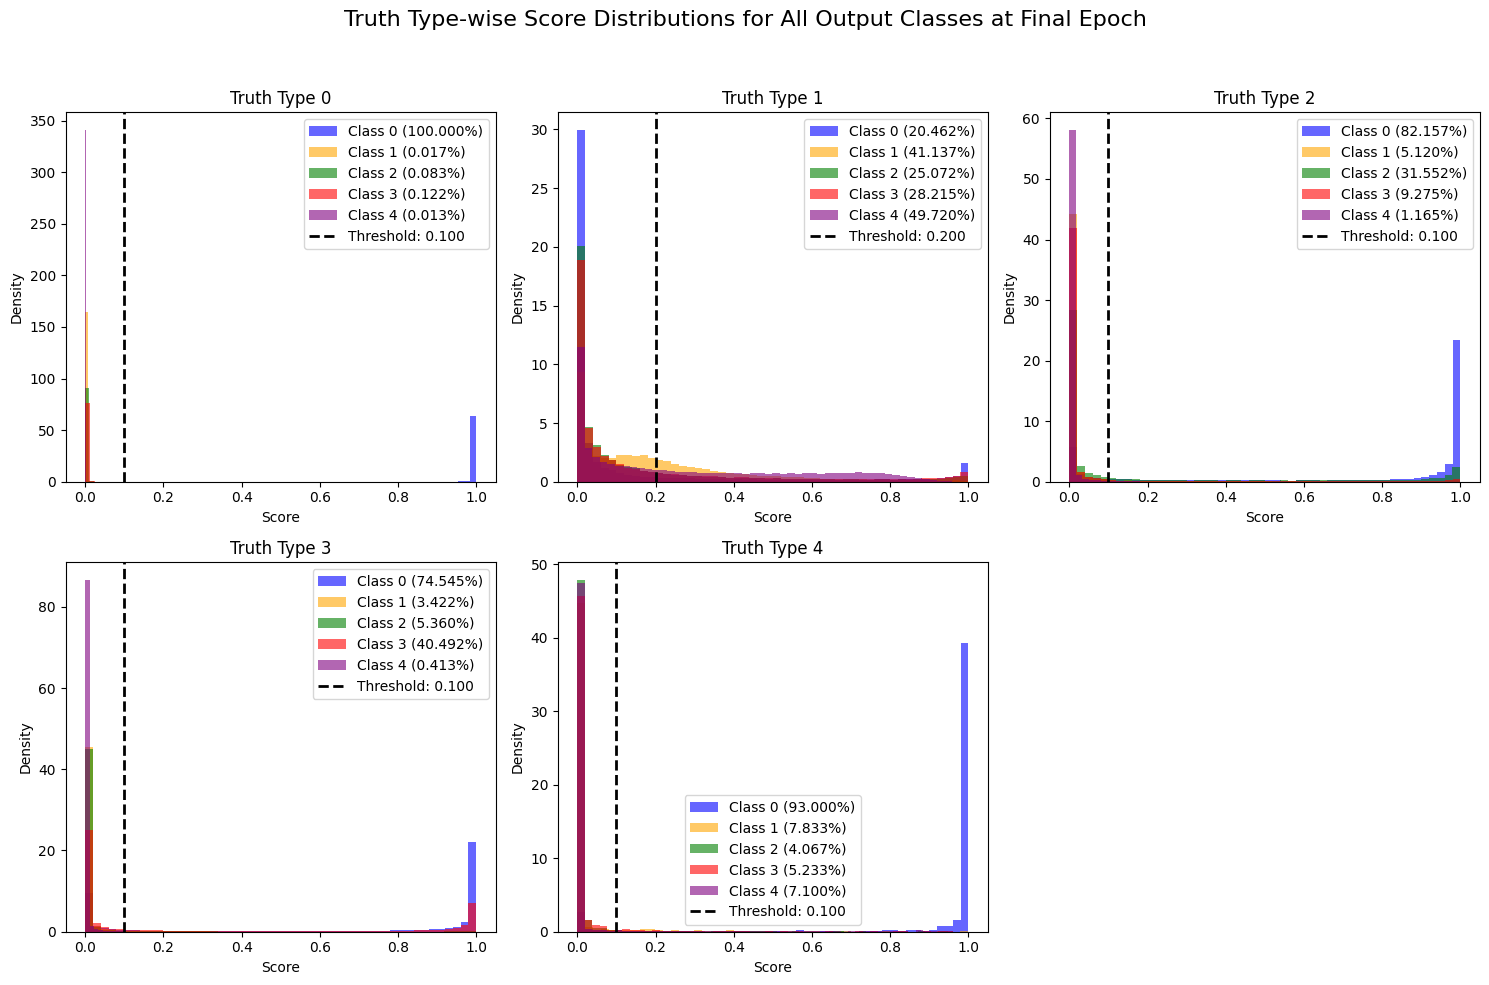

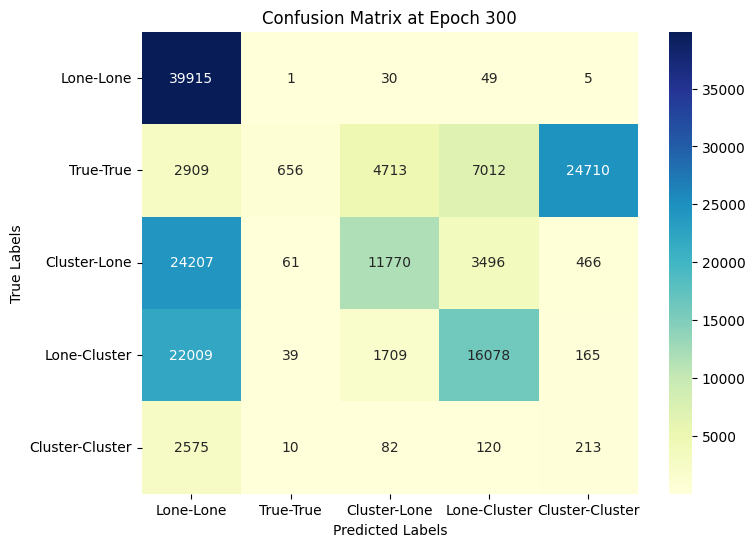

In [4]:
array_of_epochs = np.arange(len(model_GCNConv_seed42_a['loss_per_epoch']))
plt.figure(figsize=(8, 6))
plt.plot(array_of_epochs, model_GCNConv_seed42_a['loss_per_epoch'], label='Loss per Epoch')
plt.plot(array_of_epochs, model_GCNConv_seed42_a['avg_loss_training_true_class'],'dimgray', label='Avg Loss True Train')
plt.plot(array_of_epochs, model_GCNConv_seed42_a['avg_loss_testing_true_class'],'silver', label='Avg Loss True Test')
plt.plot(array_of_epochs, model_GCNConv_seed42_a['avg_loss_training_bkg_classes'],'olive', label='Avg Loss Bkg Train')
plt.plot(array_of_epochs, model_GCNConv_seed42_a['avg_loss_testing_bkg_classes'],'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for GCNConv and Class Weights with Seed 0")
plt.legend()
plt.show()

# Extract last epoch data (epoch 299)
epoch_idx = -1  # Last epoch
y_score = model_GCNConv_seed42_a['scores'][epoch_idx]  # Shape (51000, 5)
y_true = model_GCNConv_seed42_a['truth_labels'][epoch_idx]  # Shape (51000,)

# Class name mapping
class_names = {
    0: "Lone-Lone",
    1: "True-True",
    2: "Cluster-Lone",
    3: "Lone-Cluster",
    4: "Cluster-Cluster"
}

# Binarize the true labels for multi-class ROC calculation
num_classes = y_score.shape[1]
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(8, 6))
# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Last Epoch (Epoch 300)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Define class names
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Extract last epoch data
epoch_index = -1  # Last epoch
epoch_scores = model_GCNConv_seed42_a['scores'][epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = model_GCNConv_seed42_a['truth_labels'][epoch_index]  # Shape: (24000,)

optimal_thresholds = {
    'Lone-Lone': 0.1,
    'True-True': 0.2,
    'Cluster-Lone': 0.1,
    'Lone-Cluster': 0.1,
    'Cluster-Cluster': 0.1
}

class_thresholds = np.array([optimal_thresholds[label] for label in class_names])

figsize = (15, 10)

# Class-wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    ax.set_title(f'{class_name}')  # Use class name instead of "Output Class {class_idx}"
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of samples with scores > optimal threshold
        if scores_for_truth_type.size > 0:  # Avoid issues with empty slices
            fraction_above_threshold = np.mean(scores_for_truth_type > optimal_thresh)
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (> {fraction_above_threshold:.3%})',
            color=colors[truth_type % len(colors)]
        )

    # Add vertical line for the optimal threshold
    ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_thresh:.3f}')

    ax.legend()

# Hide the extra subplot if the number of classes is less than total subplots
if len(axes) > len(class_names):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Truth-type wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

unique_truth_types = sorted(np.unique(epoch_truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Determine which class is associated with this truth type
    associated_class_name = class_names[truth_type]
    associated_class_idx = truth_type  # Since classes and truth types are aligned
    optimal_threshold = optimal_thresholds[associated_class_name]  # Get the threshold

    for class_idx, class_name in enumerate(class_names):
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of scores above the associated class threshold
        if scores_for_truth_type_class.size > 0:
            fraction_above_threshold = np.mean(scores_for_truth_type_class > optimal_threshold) * 100
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} ({fraction_above_threshold:.3f}%)',
            color=colors[class_idx % len(colors)]
        )

    # Add threshold line ONLY for the associated class
    ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_threshold:.3f}')

    # Add legend with updated labels including fraction above threshold
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Map class names to numeric labels
class_labels = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
class_thresholds = np.array([optimal_thresholds[label] for label in class_labels])

# Initialize predictions with a default class of -1 (indicating no confident prediction)
y_pred = np.full(epoch_scores.shape[0], -1)

# Apply threshold-based classification
for i, label in enumerate(class_labels):  # Iterate over classes using names
    mask = epoch_scores[:, i] >= class_thresholds[i]
    y_pred[mask] = i  # Assign class index where probability exceeds threshold

# Fallback to argmax when no class exceeds threshold
y_pred[y_pred == -1] = np.argmax(epoch_scores[y_pred == -1], axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(epoch_truth_labels, y_pred, labels=[0, 1, 2, 3, 4])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix at Epoch {len(model_GCNConv_seed42_a['loss_per_epoch'])}")
plt.show()

Algorithm
* Remember you made plots of the cluster (calognn file)
* Select for everything that has a cluster involved (not Lone-Lone)

Plot these
* Color code based on which type it is
* For each calo layer, zoom in and show what is hit and what belongs to what
* In a different notebook, load in the labels and the features

Make 12 versions of these GCNConv plots and gather the ROC Curves and AUC curves and then make distributions of the AUC

Make a beefy GAT model
* 32 heads
* 12 layers

Play with the weights
* By hand, get an understanding of what happens

Don't use the notebooks for training - Long Term Goal
* Use switches, designate GPUs, write scripts
* Make it so that you can run many many models by only giving it the "knobs/keys"

# Model Details

Main Model Layer: GCNConv

Random Seed: 42

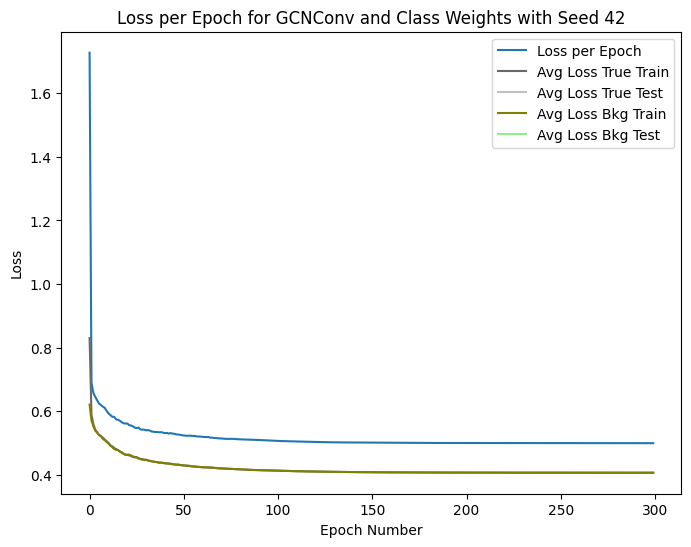

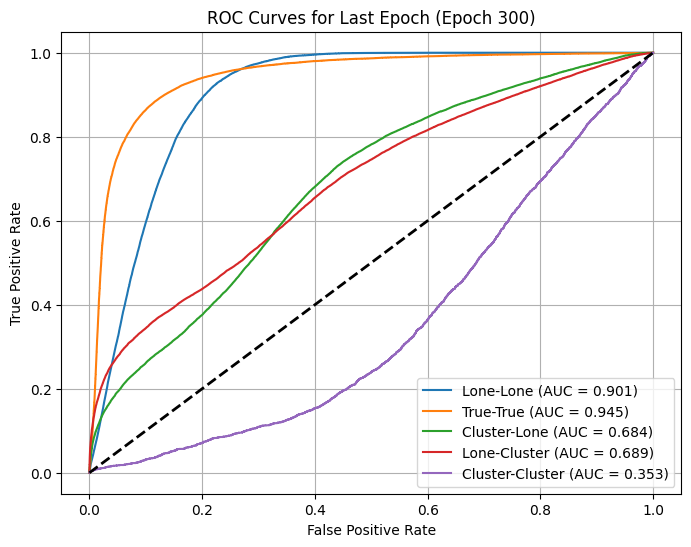

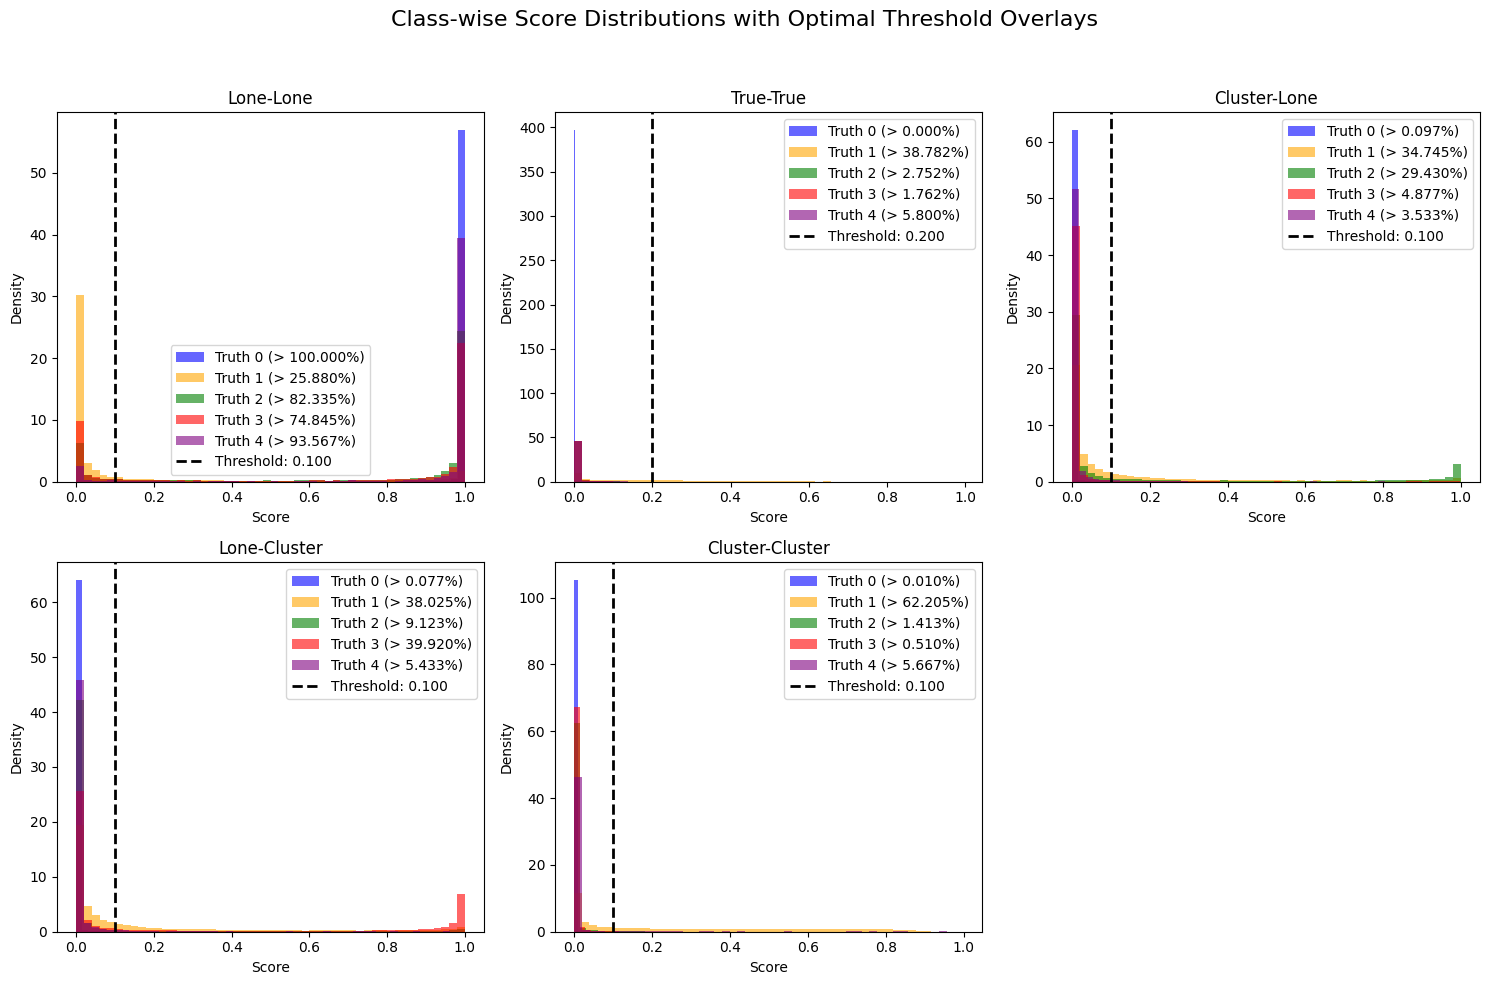

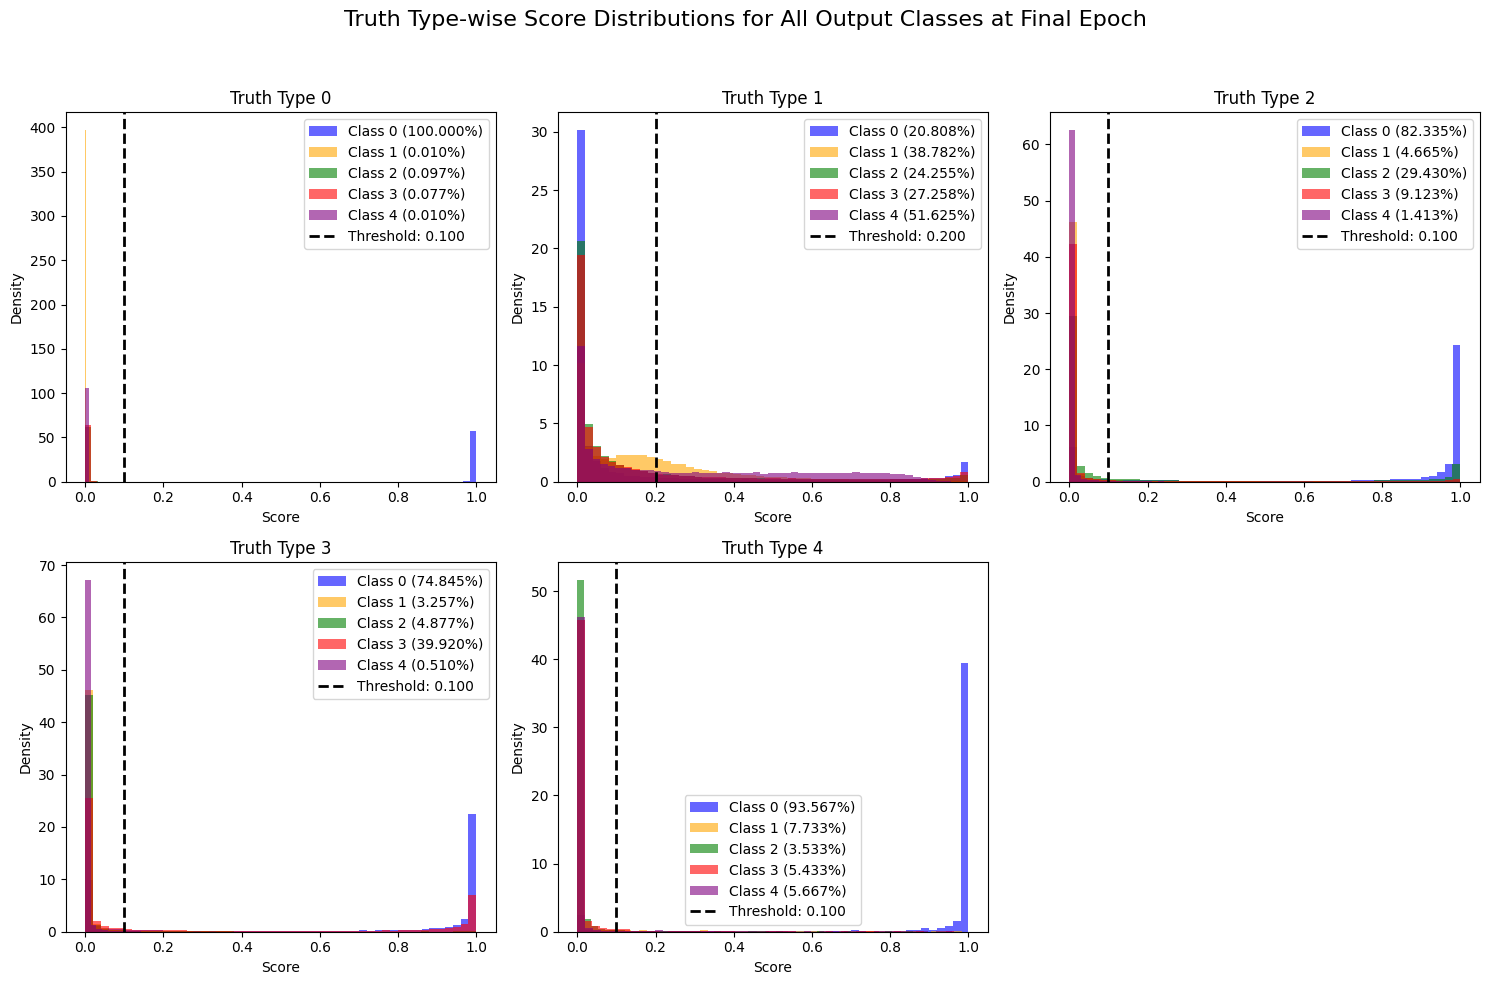

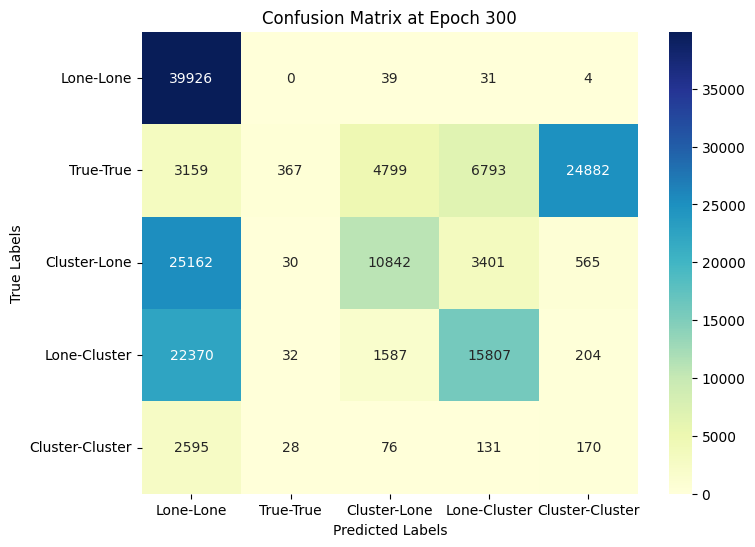

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(array_of_epochs, model_GCNConv_seed42_b['loss_per_epoch'], label='Loss per Epoch')
plt.plot(array_of_epochs, model_GCNConv_seed42_b['avg_loss_training_true_class'],'dimgray', label='Avg Loss True Train')
plt.plot(array_of_epochs, model_GCNConv_seed42_b['avg_loss_testing_true_class'],'silver', label='Avg Loss True Test')
plt.plot(array_of_epochs, model_GCNConv_seed42_b['avg_loss_training_bkg_classes'],'olive', label='Avg Loss Bkg Train')
plt.plot(array_of_epochs, model_GCNConv_seed42_b['avg_loss_testing_bkg_classes'],'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for GCNConv and Class Weights with Seed 42")
plt.legend()
plt.show()

# Extract last epoch data (epoch 299)
epoch_idx = -1  # Last epoch
y_score = model_GCNConv_seed42_b['scores'][epoch_idx]  # Shape (51000, 5)
y_true = model_GCNConv_seed42_b['truth_labels'][epoch_idx]  # Shape (51000,)

# Class name mapping
class_names = {
    0: "Lone-Lone",
    1: "True-True",
    2: "Cluster-Lone",
    3: "Lone-Cluster",
    4: "Cluster-Cluster"
}

# Binarize the true labels for multi-class ROC calculation
num_classes = y_score.shape[1]
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(8, 6))
# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Last Epoch (Epoch 300)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Define class names
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Extract last epoch data
epoch_index = -1  # Last epoch
epoch_scores = model_GCNConv_seed42_b['scores'][epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = model_GCNConv_seed42_b['truth_labels'][epoch_index]  # Shape: (24000,)

optimal_thresholds = {
    'Lone-Lone': 0.1,
    'True-True': 0.2,
    'Cluster-Lone': 0.1,
    'Lone-Cluster': 0.1,
    'Cluster-Cluster': 0.1
}

class_thresholds = np.array([optimal_thresholds[label] for label in class_names])

figsize = (15, 10)

# Class-wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    ax.set_title(f'{class_name}')  # Use class name instead of "Output Class {class_idx}"
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of samples with scores > optimal threshold
        if scores_for_truth_type.size > 0:  # Avoid issues with empty slices
            fraction_above_threshold = np.mean(scores_for_truth_type > optimal_thresh)
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (> {fraction_above_threshold:.3%})',
            color=colors[truth_type % len(colors)]
        )

    # Add vertical line for the optimal threshold
    ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_thresh:.3f}')

    ax.legend()

# Hide the extra subplot if the number of classes is less than total subplots
if len(axes) > len(class_names):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Truth-type wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

unique_truth_types = sorted(np.unique(epoch_truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Determine which class is associated with this truth type
    associated_class_name = class_names[truth_type]
    associated_class_idx = truth_type  # Since classes and truth types are aligned
    optimal_threshold = optimal_thresholds[associated_class_name]  # Get the threshold

    for class_idx, class_name in enumerate(class_names):
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of scores above the associated class threshold
        if scores_for_truth_type_class.size > 0:
            fraction_above_threshold = np.mean(scores_for_truth_type_class > optimal_threshold) * 100
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} ({fraction_above_threshold:.3f}%)',
            color=colors[class_idx % len(colors)]
        )

    # Add threshold line ONLY for the associated class
    ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_threshold:.3f}')

    # Add legend with updated labels including fraction above threshold
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Map class names to numeric labels
class_labels = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
class_thresholds = np.array([optimal_thresholds[label] for label in class_labels])

# Initialize predictions with a default class of -1 (indicating no confident prediction)
y_pred = np.full(epoch_scores.shape[0], -1)

# Apply threshold-based classification
for i, label in enumerate(class_labels):  # Iterate over classes using names
    mask = epoch_scores[:, i] >= class_thresholds[i]
    y_pred[mask] = i  # Assign class index where probability exceeds threshold

# Fallback to argmax when no class exceeds threshold
y_pred[y_pred == -1] = np.argmax(epoch_scores[y_pred == -1], axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(epoch_truth_labels, y_pred, labels=[0, 1, 2, 3, 4])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix at Epoch {len(model_GCNConv_seed42_b['loss_per_epoch'])}")
plt.show()

# Model Details

Main Model Layer: GCNConv

Random Seed: 0

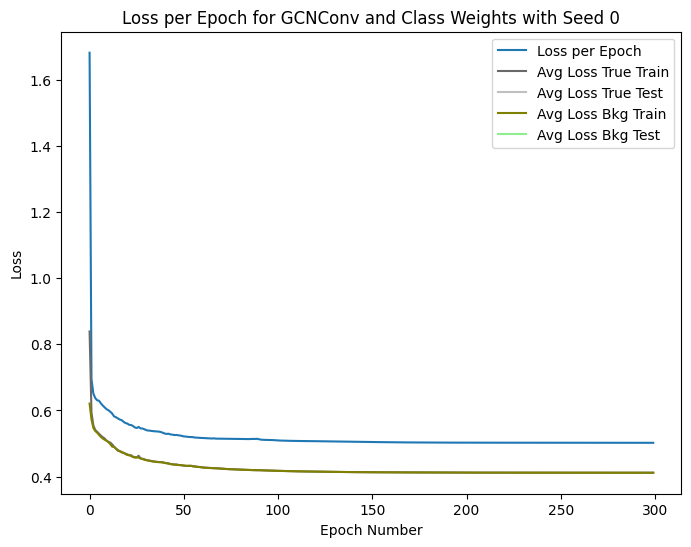

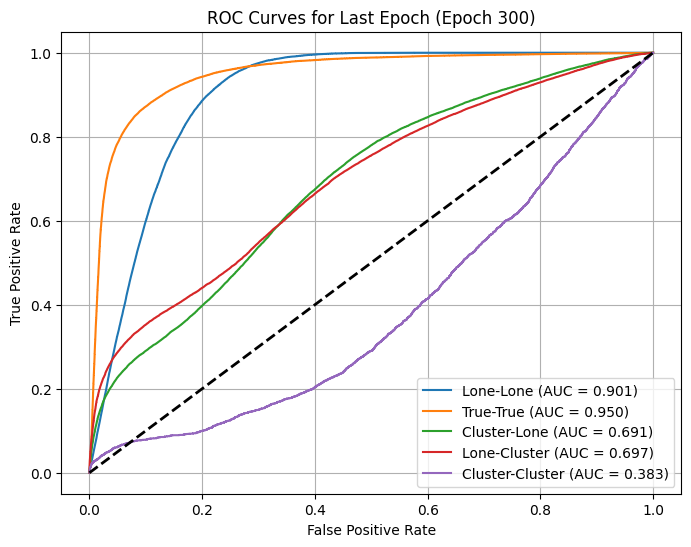

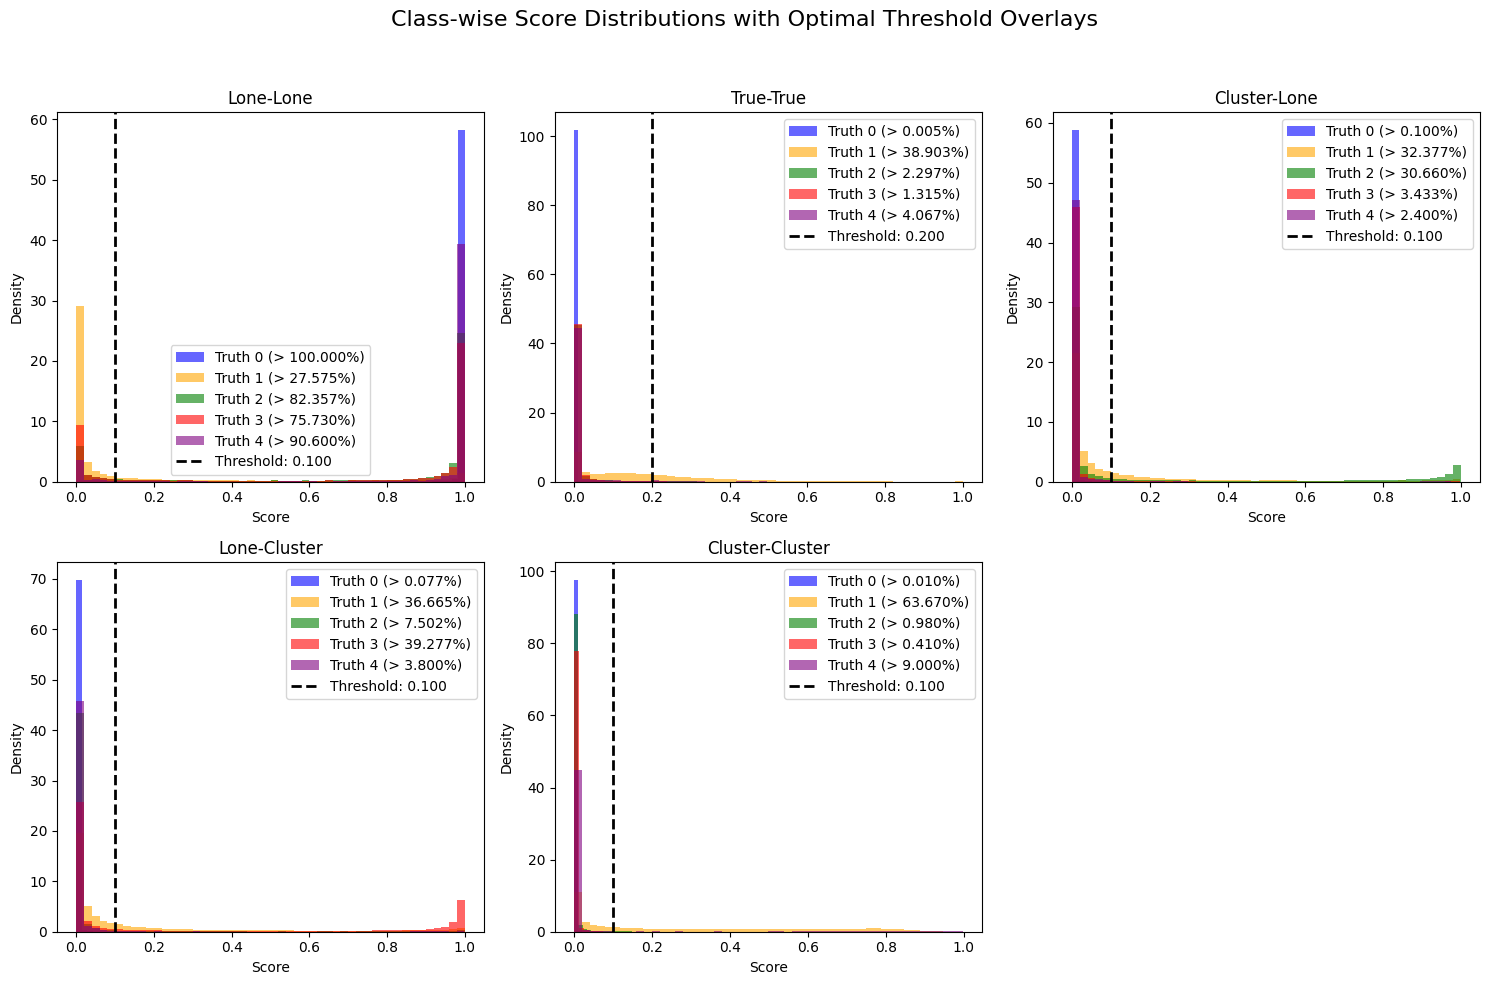

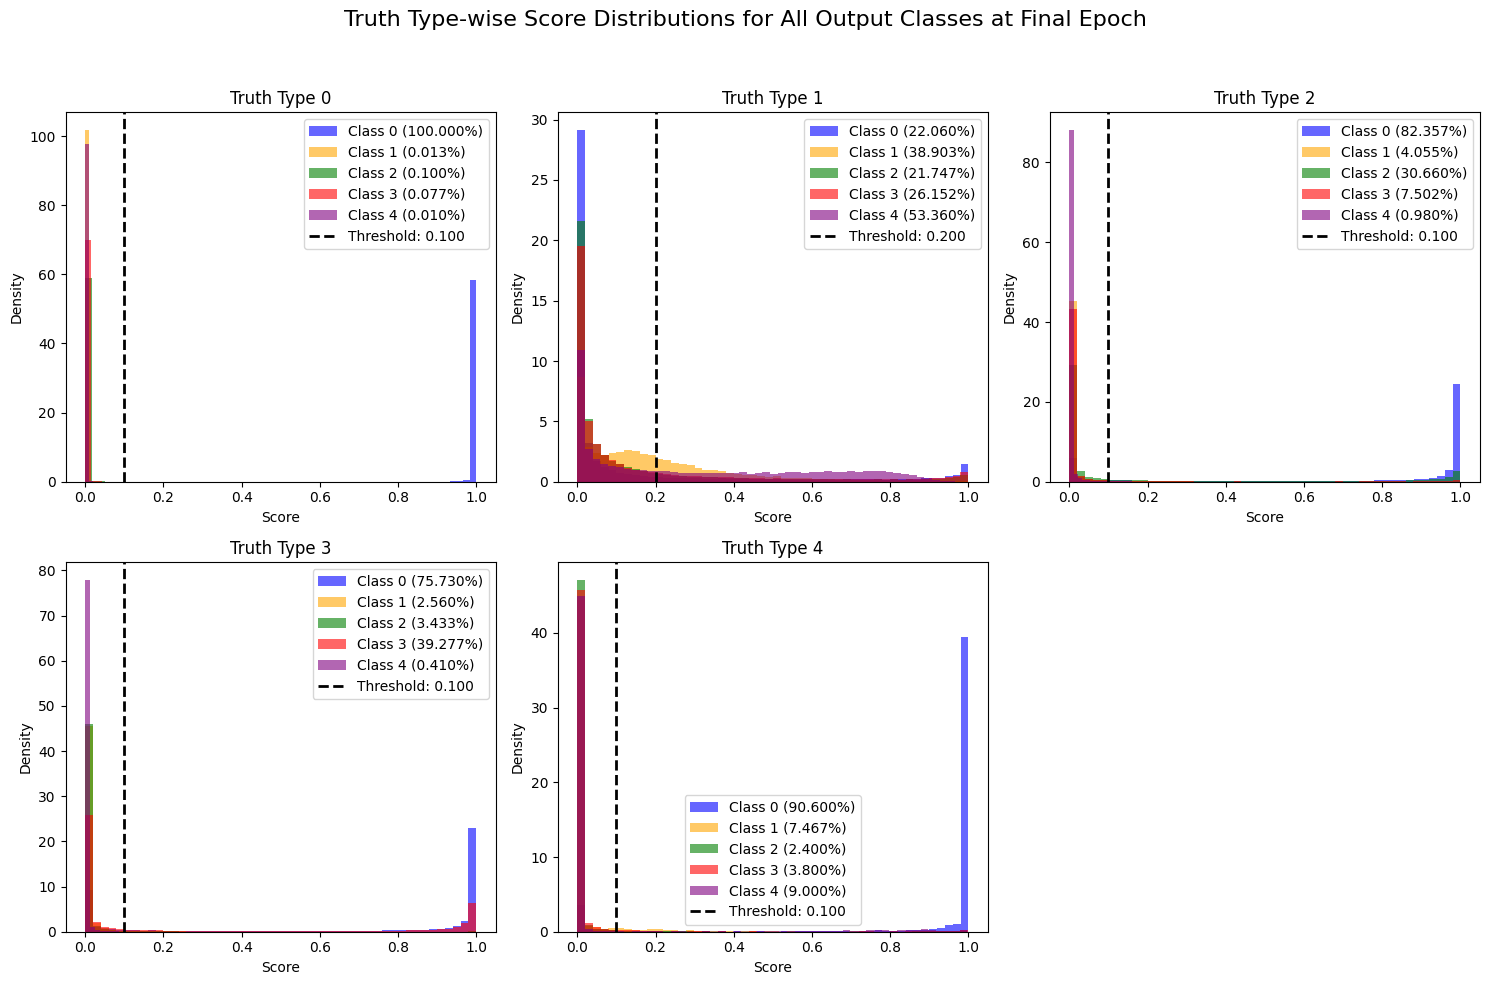

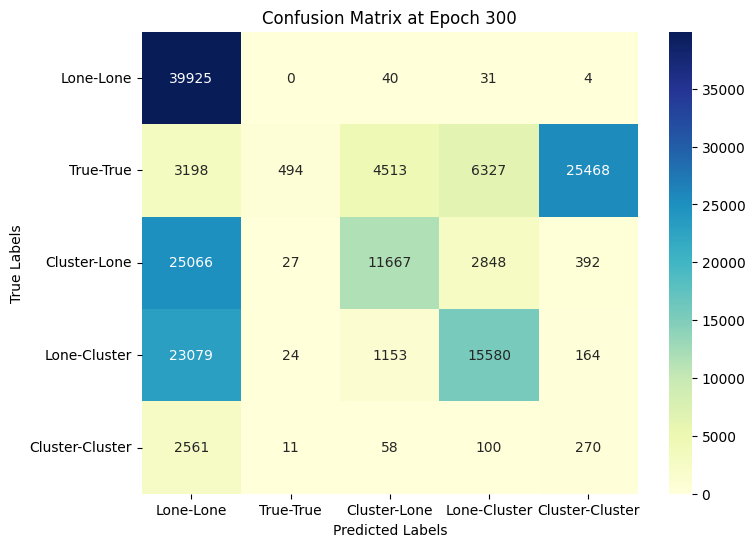

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(array_of_epochs, model_GCNConv_seed0['loss_per_epoch'], label='Loss per Epoch')
plt.plot(array_of_epochs, model_GCNConv_seed0['avg_loss_training_true_class'],'dimgray', label='Avg Loss True Train')
plt.plot(array_of_epochs, model_GCNConv_seed0['avg_loss_testing_true_class'],'silver', label='Avg Loss True Test')
plt.plot(array_of_epochs, model_GCNConv_seed0['avg_loss_training_bkg_classes'],'olive', label='Avg Loss Bkg Train')
plt.plot(array_of_epochs, model_GCNConv_seed0['avg_loss_testing_bkg_classes'],'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for GCNConv and Class Weights with Seed 0")
plt.legend()
plt.show()

# Extract last epoch data (epoch 299)
epoch_idx = -1  # Last epoch
y_score = model_GCNConv_seed0['scores'][epoch_idx]  # Shape (51000, 5)
y_true = model_GCNConv_seed0['truth_labels'][epoch_idx]  # Shape (51000,)

# Class name mapping
class_names = {
    0: "Lone-Lone",
    1: "True-True",
    2: "Cluster-Lone",
    3: "Lone-Cluster",
    4: "Cluster-Cluster"
}

# Binarize the true labels for multi-class ROC calculation
num_classes = y_score.shape[1]
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(8, 6))
# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Last Epoch (Epoch 300)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Define class names
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Extract last epoch data
epoch_index = -1  # Last epoch
epoch_scores = model_GCNConv_seed0['scores'][epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = model_GCNConv_seed0['truth_labels'][epoch_index]  # Shape: (24000,)

optimal_thresholds = {
    'Lone-Lone': 0.1,
    'True-True': 0.2,
    'Cluster-Lone': 0.1,
    'Lone-Cluster': 0.1,
    'Cluster-Cluster': 0.1
}

class_thresholds = np.array([optimal_thresholds[label] for label in class_names])

figsize = (15, 10)

# Class-wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    ax.set_title(f'{class_name}')  # Use class name instead of "Output Class {class_idx}"
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of samples with scores > optimal threshold
        if scores_for_truth_type.size > 0:  # Avoid issues with empty slices
            fraction_above_threshold = np.mean(scores_for_truth_type > optimal_thresh)
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (> {fraction_above_threshold:.3%})',
            color=colors[truth_type % len(colors)]
        )

    # Add vertical line for the optimal threshold
    ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_thresh:.3f}')

    ax.legend()

# Hide the extra subplot if the number of classes is less than total subplots
if len(axes) > len(class_names):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Truth-type wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

unique_truth_types = sorted(np.unique(epoch_truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Determine which class is associated with this truth type
    associated_class_name = class_names[truth_type]
    associated_class_idx = truth_type  # Since classes and truth types are aligned
    optimal_threshold = optimal_thresholds[associated_class_name]  # Get the threshold

    for class_idx, class_name in enumerate(class_names):
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of scores above the associated class threshold
        if scores_for_truth_type_class.size > 0:
            fraction_above_threshold = np.mean(scores_for_truth_type_class > optimal_threshold) * 100
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} ({fraction_above_threshold:.3f}%)',
            color=colors[class_idx % len(colors)]
        )

    # Add threshold line ONLY for the associated class
    ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_threshold:.3f}')

    # Add legend with updated labels including fraction above threshold
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Map class names to numeric labels
class_labels = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
class_thresholds = np.array([optimal_thresholds[label] for label in class_labels])

# Initialize predictions with a default class of -1 (indicating no confident prediction)
y_pred = np.full(epoch_scores.shape[0], -1)

# Apply threshold-based classification
for i, label in enumerate(class_labels):  # Iterate over classes using names
    mask = epoch_scores[:, i] >= class_thresholds[i]
    y_pred[mask] = i  # Assign class index where probability exceeds threshold

# Fallback to argmax when no class exceeds threshold
y_pred[y_pred == -1] = np.argmax(epoch_scores[y_pred == -1], axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(epoch_truth_labels, y_pred, labels=[0, 1, 2, 3, 4])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix at Epoch {len(model_GCNConv_seed0['loss_per_epoch'])}")
plt.show()

# Model Details

Main Model Layer: GAT

Random Seed: 42

Number of Heads: 4

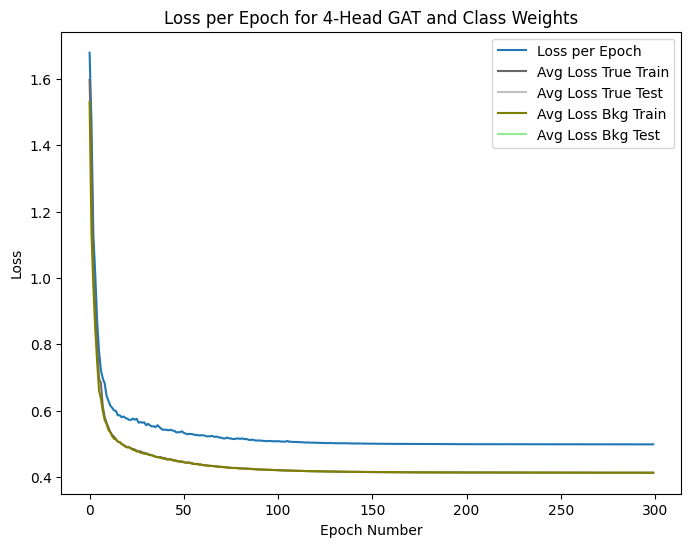

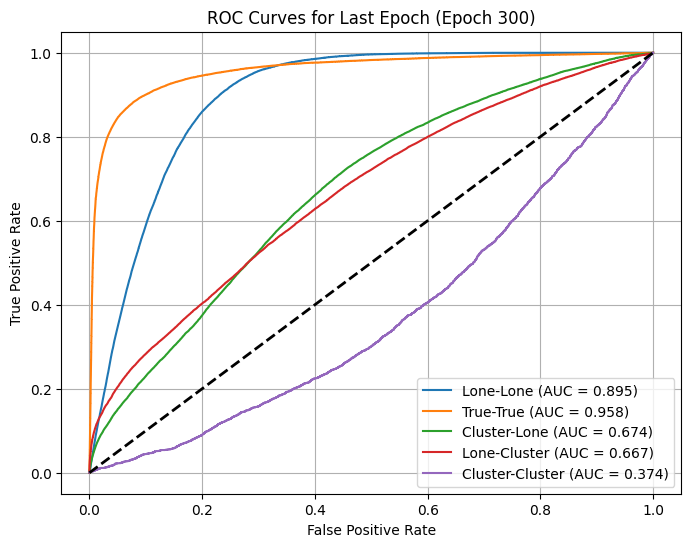

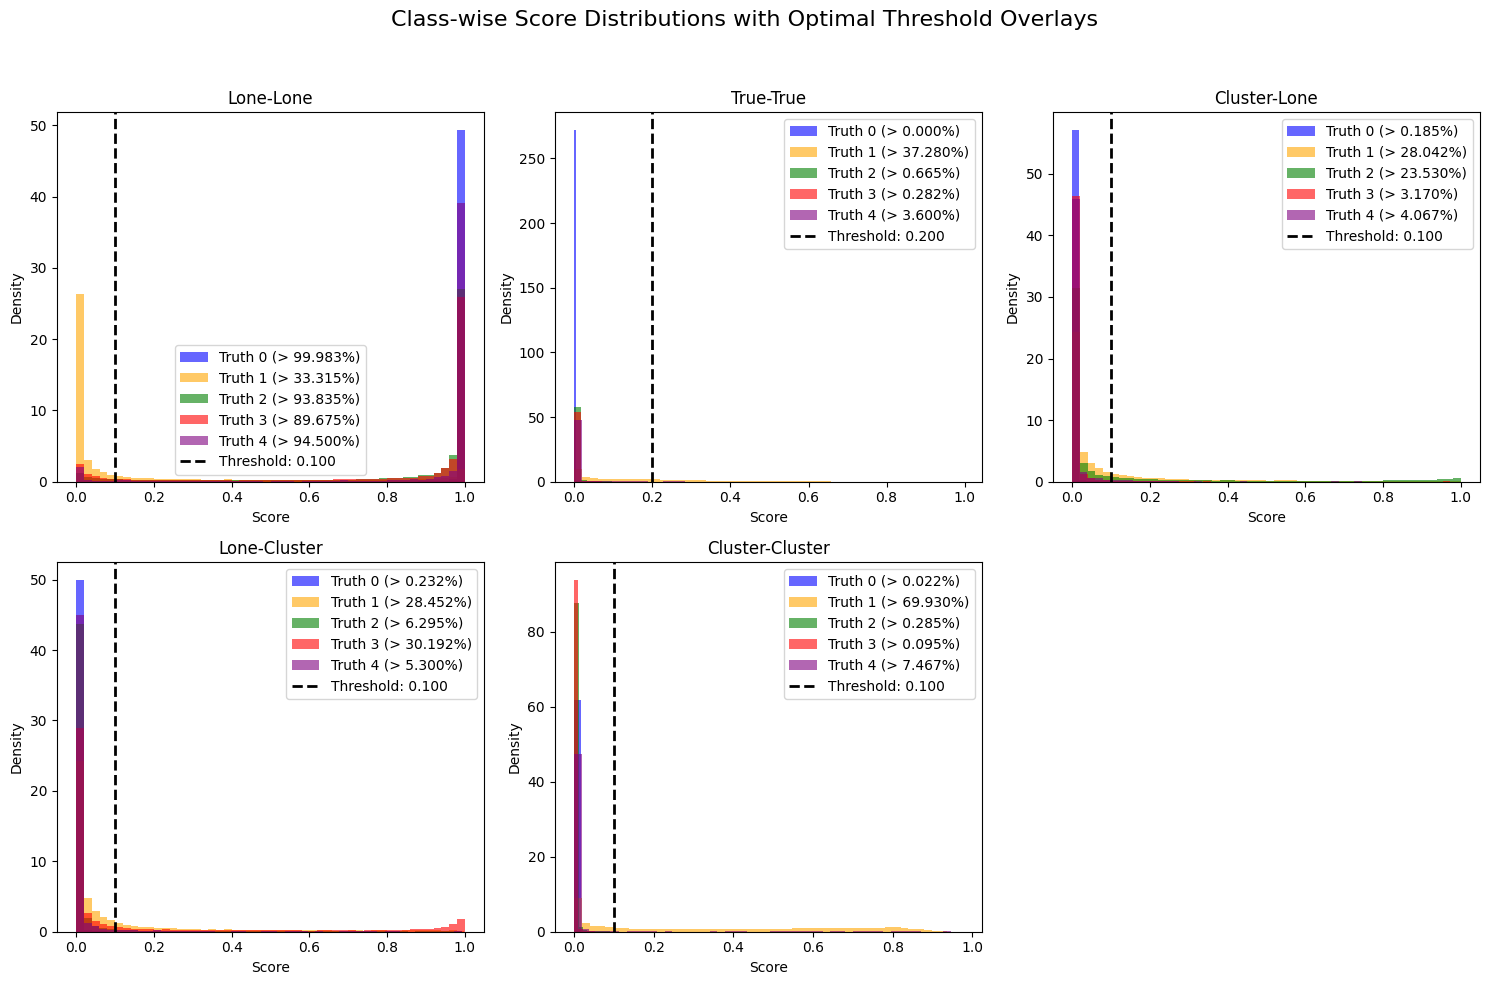

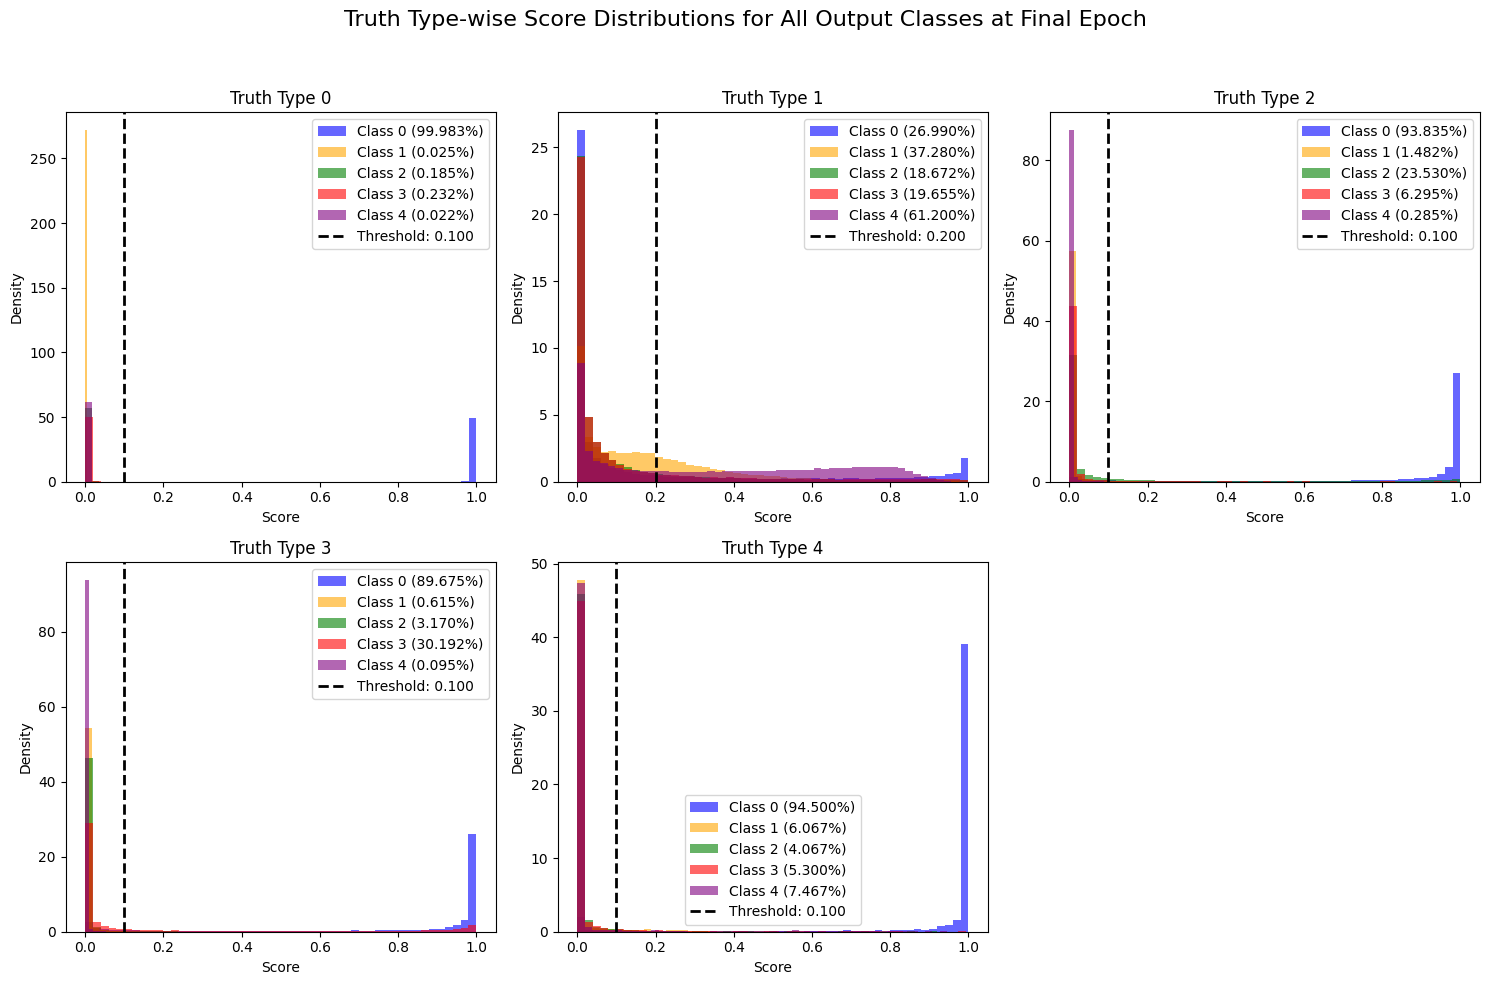

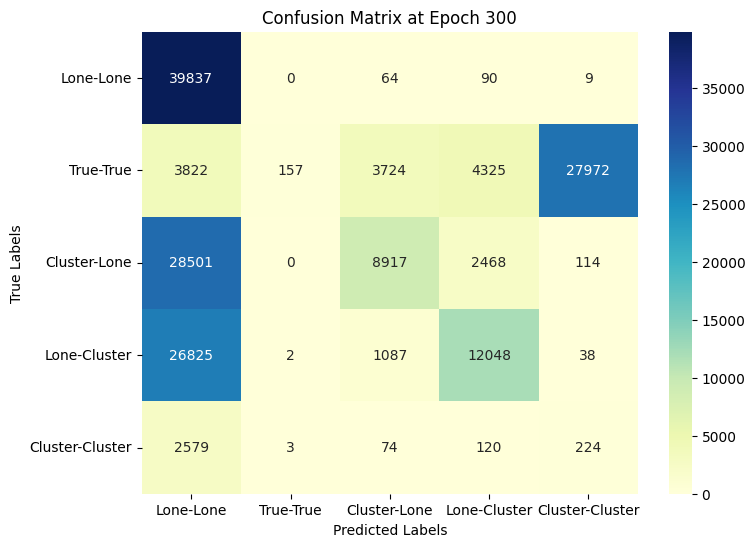

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(array_of_epochs, model_GAT_4_heads['loss_per_epoch'], label='Loss per Epoch')
plt.plot(array_of_epochs, model_GAT_4_heads['avg_loss_training_true_class'],'dimgray', label='Avg Loss True Train')
plt.plot(array_of_epochs, model_GAT_4_heads['avg_loss_testing_true_class'],'silver', label='Avg Loss True Test')
plt.plot(array_of_epochs, model_GAT_4_heads['avg_loss_training_bkg_classes'],'olive', label='Avg Loss Bkg Train')
plt.plot(array_of_epochs, model_GAT_4_heads['avg_loss_testing_bkg_classes'],'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for 4-Head GAT and Class Weights")
plt.legend()
plt.show()

# Extract last epoch data (epoch 299)
epoch_idx = -1  # Last epoch
y_score = model_GAT_4_heads['scores'][epoch_idx]  # Shape (51000, 5)
y_true = model_GAT_4_heads['truth_labels'][epoch_idx]  # Shape (51000,)

# Class name mapping
class_names = {
    0: "Lone-Lone",
    1: "True-True",
    2: "Cluster-Lone",
    3: "Lone-Cluster",
    4: "Cluster-Cluster"
}

# Binarize the true labels for multi-class ROC calculation
num_classes = y_score.shape[1]
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(8, 6))
# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Last Epoch (Epoch 300)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Define class names
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Extract last epoch data
epoch_index = -1  # Last epoch
epoch_scores = model_GAT_4_heads['scores'][epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = model_GAT_4_heads['truth_labels'][epoch_index]  # Shape: (24000,)

optimal_thresholds = {
    'Lone-Lone': 0.1,
    'True-True': 0.2,
    'Cluster-Lone': 0.1,
    'Lone-Cluster': 0.1,
    'Cluster-Cluster': 0.1
}

class_thresholds = np.array([optimal_thresholds[label] for label in class_names])

figsize = (15, 10)

# Class-wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    ax.set_title(f'{class_name}')  # Use class name instead of "Output Class {class_idx}"
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of samples with scores > optimal threshold
        if scores_for_truth_type.size > 0:  # Avoid issues with empty slices
            fraction_above_threshold = np.mean(scores_for_truth_type > optimal_thresh)
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (> {fraction_above_threshold:.3%})',
            color=colors[truth_type % len(colors)]
        )

    # Add vertical line for the optimal threshold
    ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_thresh:.3f}')

    ax.legend()

# Hide the extra subplot if the number of classes is less than total subplots
if len(axes) > len(class_names):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Truth-type wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

unique_truth_types = sorted(np.unique(epoch_truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Determine which class is associated with this truth type
    associated_class_name = class_names[truth_type]
    associated_class_idx = truth_type  # Since classes and truth types are aligned
    optimal_threshold = optimal_thresholds[associated_class_name]  # Get the threshold

    for class_idx, class_name in enumerate(class_names):
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of scores above the associated class threshold
        if scores_for_truth_type_class.size > 0:
            fraction_above_threshold = np.mean(scores_for_truth_type_class > optimal_threshold) * 100
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} ({fraction_above_threshold:.3f}%)',
            color=colors[class_idx % len(colors)]
        )

    # Add threshold line ONLY for the associated class
    ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_threshold:.3f}')

    # Add legend with updated labels including fraction above threshold
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Map class names to numeric labels
class_labels = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
class_thresholds = np.array([optimal_thresholds[label] for label in class_labels])

# Initialize predictions with a default class of -1 (indicating no confident prediction)
y_pred = np.full(epoch_scores.shape[0], -1)

# Apply threshold-based classification
for i, label in enumerate(class_labels):  # Iterate over classes using names
    mask = epoch_scores[:, i] >= class_thresholds[i]
    y_pred[mask] = i  # Assign class index where probability exceeds threshold

# Fallback to argmax when no class exceeds threshold
y_pred[y_pred == -1] = np.argmax(epoch_scores[y_pred == -1], axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(epoch_truth_labels, y_pred, labels=[0, 1, 2, 3, 4])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix at Epoch {len(model_GAT_4_heads['loss_per_epoch'])}")
plt.show()

# Model Details

Main Model Layer: GAT

Random Seed: 42

Number of Heads: 8

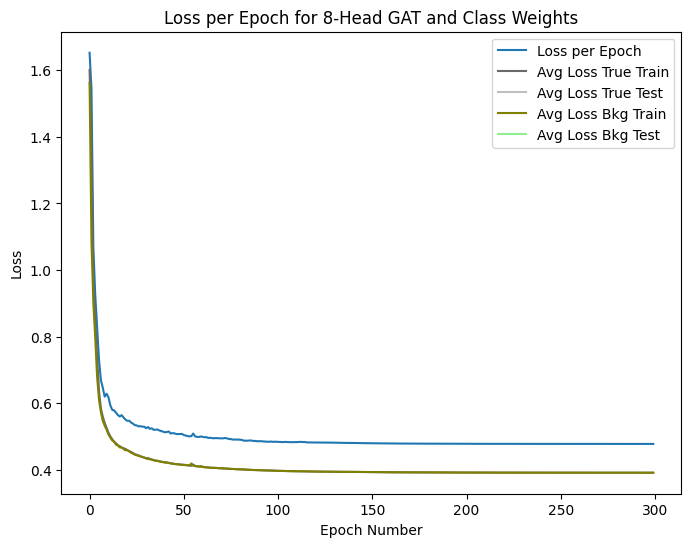

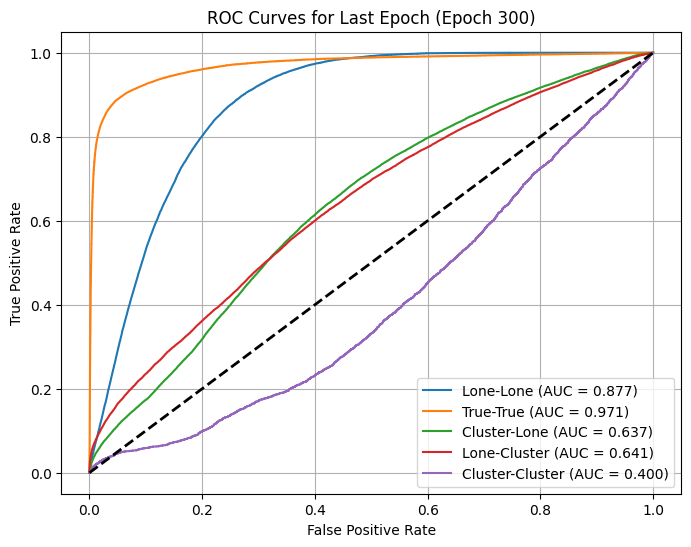

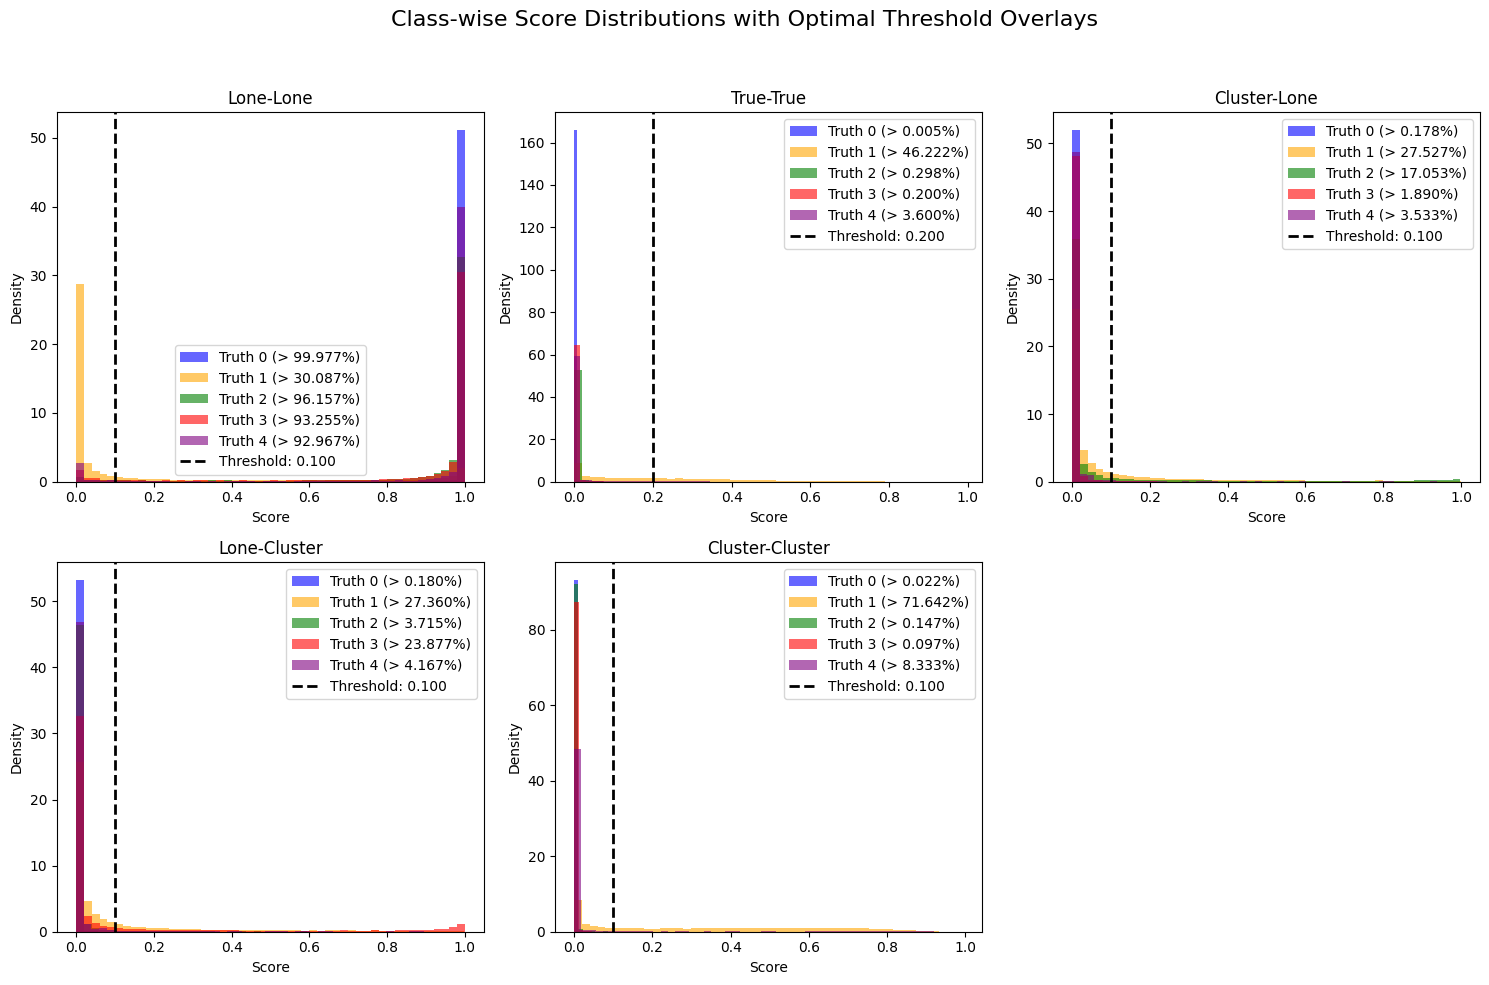

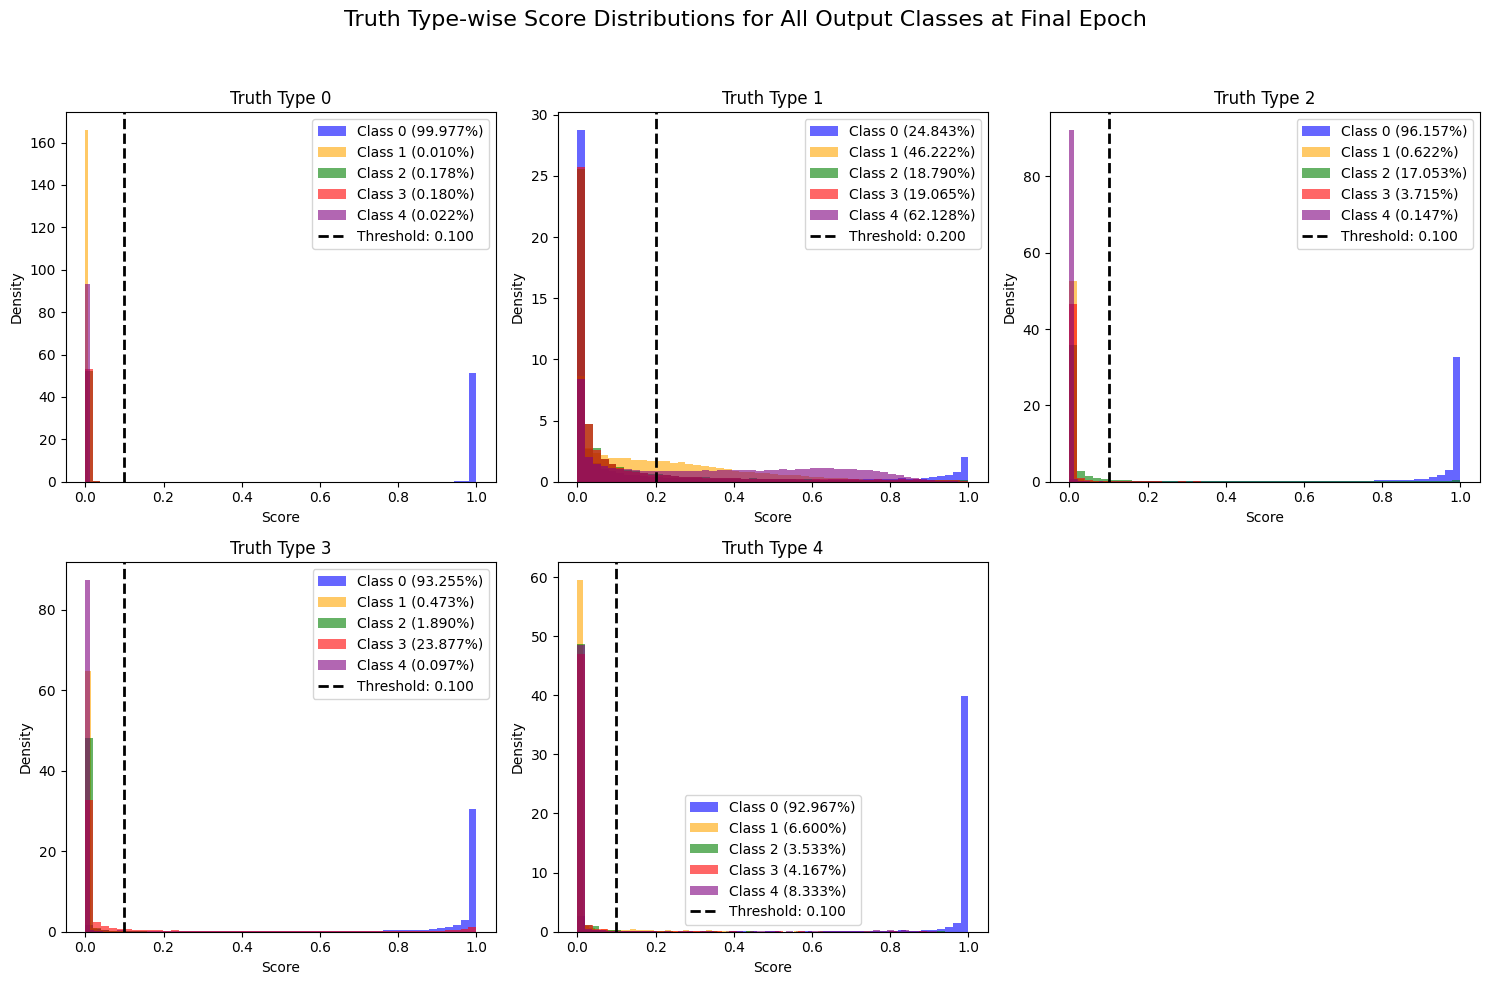

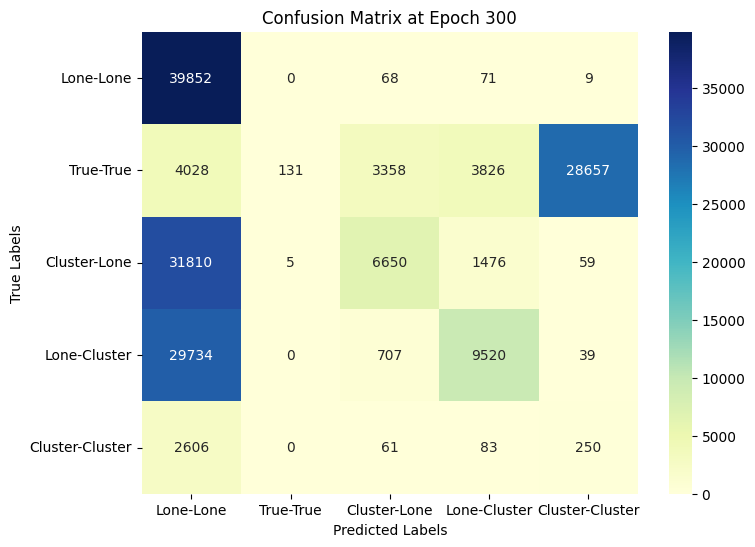

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(array_of_epochs, model_GAT_8_heads['loss_per_epoch'], label='Loss per Epoch')
plt.plot(array_of_epochs, model_GAT_8_heads['avg_loss_training_true_class'],'dimgray', label='Avg Loss True Train')
plt.plot(array_of_epochs, model_GAT_8_heads['avg_loss_testing_true_class'],'silver', label='Avg Loss True Test')
plt.plot(array_of_epochs, model_GAT_8_heads['avg_loss_training_bkg_classes'],'olive', label='Avg Loss Bkg Train')
plt.plot(array_of_epochs, model_GAT_8_heads['avg_loss_testing_bkg_classes'],'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for 8-Head GAT and Class Weights")
plt.legend()
plt.show()

# Extract last epoch data (epoch 299)
epoch_idx = -1  # Last epoch
y_score = model_GAT_8_heads['scores'][epoch_idx]  # Shape (51000, 5)
y_true = model_GAT_8_heads['truth_labels'][epoch_idx]  # Shape (51000,)

# Class name mapping
class_names = {
    0: "Lone-Lone",
    1: "True-True",
    2: "Cluster-Lone",
    3: "Lone-Cluster",
    4: "Cluster-Cluster"
}

# Binarize the true labels for multi-class ROC calculation
num_classes = y_score.shape[1]
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(8, 6))
# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Last Epoch (Epoch 300)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Define class names
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Extract last epoch data
epoch_index = -1  # Last epoch
epoch_scores = model_GAT_8_heads['scores'][epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = model_GAT_8_heads['truth_labels'][epoch_index]  # Shape: (24000,)

optimal_thresholds = {
    'Lone-Lone': 0.1,
    'True-True': 0.2,
    'Cluster-Lone': 0.1,
    'Lone-Cluster': 0.1,
    'Cluster-Cluster': 0.1
}

class_thresholds = np.array([optimal_thresholds[label] for label in class_names])

figsize = (15, 10)

# Class-wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    ax.set_title(f'{class_name}')  # Use class name instead of "Output Class {class_idx}"
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of samples with scores > optimal threshold
        if scores_for_truth_type.size > 0:  # Avoid issues with empty slices
            fraction_above_threshold = np.mean(scores_for_truth_type > optimal_thresh)
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (> {fraction_above_threshold:.3%})',
            color=colors[truth_type % len(colors)]
        )

    # Add vertical line for the optimal threshold
    ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_thresh:.3f}')

    ax.legend()

# Hide the extra subplot if the number of classes is less than total subplots
if len(axes) > len(class_names):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Truth-type wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

unique_truth_types = sorted(np.unique(epoch_truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Determine which class is associated with this truth type
    associated_class_name = class_names[truth_type]
    associated_class_idx = truth_type  # Since classes and truth types are aligned
    optimal_threshold = optimal_thresholds[associated_class_name]  # Get the threshold

    for class_idx, class_name in enumerate(class_names):
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of scores above the associated class threshold
        if scores_for_truth_type_class.size > 0:
            fraction_above_threshold = np.mean(scores_for_truth_type_class > optimal_threshold) * 100
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} ({fraction_above_threshold:.3f}%)',
            color=colors[class_idx % len(colors)]
        )

    # Add threshold line ONLY for the associated class
    ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_threshold:.3f}')

    # Add legend with updated labels including fraction above threshold
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Map class names to numeric labels
class_labels = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
class_thresholds = np.array([optimal_thresholds[label] for label in class_labels])

# Initialize predictions with a default class of -1 (indicating no confident prediction)
y_pred = np.full(epoch_scores.shape[0], -1)

# Apply threshold-based classification
for i, label in enumerate(class_labels):  # Iterate over classes using names
    mask = epoch_scores[:, i] >= class_thresholds[i]
    y_pred[mask] = i  # Assign class index where probability exceeds threshold

# Fallback to argmax when no class exceeds threshold
y_pred[y_pred == -1] = np.argmax(epoch_scores[y_pred == -1], axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(epoch_truth_labels, y_pred, labels=[0, 1, 2, 3, 4])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix at Epoch {len(model_GAT_8_heads['loss_per_epoch'])}")
plt.show()